In [2]:
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

import albumentations as A
AUTOTUNE = tf.data.experimental.AUTOTUNE

2022-05-09 14:20:36.634724: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Data Load & DataSet 생성

- get data(data_dir) : 경로입력하면 해당 경로의 폴더내의 이미지 경로를 리스트로 리턴
- load_img_numpy(img_dir, mask_dir, target_size) : 이미지 경로, 마스크 경로, target_size(resize할 사이즈)를 입력하면 지정한 사이즈의 이미지와 마스크를 numpy array로 리턴
- create dataset(img_dir, mask_dir, batch_size) : 이미지폴더경로, 마스크폴더경로, 배치처리를 한다면 배치 사이즈 입력하면 dataset을 생성하여 리턴

In [3]:
def get_data(data_dir):
    # get image path
    img_path = os.listdir(data_dir)
    try :
        img_path.remove('.ipynb_checkpoints')
    except:
        pass
    img_path_list = [os.path.join(data_dir, x) for x in img_path]
    img_path_list = sorted(img_path_list)
    return img_path_list  # img 들의 경로를 리스트로 리턴

def load_img_numpy(img_dir, mask_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0 # normalize
    
    mask = cv2.imread(mask_dir)
    mask = cv2.resize(mask, dsize=target_size)
    mask = mask[..., :1]
    mask = mask.astype(np.float32)
    return img, mask

In [4]:
def create_dataset(img_dir, mask_dir, target_size, batch_size=None) :
    x_img_dir = get_data(img_dir)
    y_img_dir = get_data(mask_dir)
    
    x_img = [] # 원본이미지
    y_img = [] # 마스크 이미지
    
    ## 최적화가 필요한 부분
    for i, m in tqdm(zip(x_img_dir, y_img_dir),
                     total=len(x_img_dir),
                     position=0,
                     leave=True):
        img, mask = load_img_numpy(i, m, target_size)
        x_img.append(img)
        y_img.append(mask)
        
    x = Dataset.from_tensor_slices(x_img)
    y = Dataset.from_tensor_slices(y_img)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

In [96]:
##### 경로 설정 ######
DATA_DIR = './data/segmentation'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'valid')
y_valid_dir = os.path.join(DATA_DIR, 'validannot')

#x_test_dir = os.path.join(DATA_DIR, 'test')
x_test_dir = './data/train_images' ## 모든 이미지 !
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 4

train_dataset = create_dataset(x_train_dir, y_train_dir, (IMAGE_SIZE,IMAGE_SIZE), BATCH_SIZE)
print('train dataset has made!')
valid_dataset = create_dataset(x_valid_dir, y_valid_dir, (IMAGE_SIZE,IMAGE_SIZE), BATCH_SIZE)
print('valid dataset has made!')

  0%|          | 0/228 [00:00<?, ?it/s]

2022-05-09 14:21:34.224078: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-09 14:21:34.225200: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-09 14:21:34.249471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 14:21:34.250049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-05-09 14:21:34.250079: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-09 14:21:34.251962: I tensorflow/stream_executor/platform/default/dso_loade

train dataset has made!


A node zero
2022-05-09 14:21:34.261969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 14:21:34.262504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0
2022-05-09 14:21:34.262955: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 14:21:34.263357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 14:21:34.263920: I tensorflow/core/common_runtime/gpu/

  0%|          | 0/50 [00:00<?, ?it/s]

valid dataset has made!


In [7]:
train_dataset

<RepeatDataset shapes: ((4, 256, 256, 3), (4, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [8]:
valid_dataset

<RepeatDataset shapes: ((4, 256, 256, 3), (4, 256, 256, 1)), types: (tf.float32, tf.float32)>

((img, mask)) : ((batch_size, width, heigth, channels), (batch_size, width, height, channels))

In [69]:
def visualize_history(hist, m) :
    loss = hist.history[m]
    val_loss = hist.history['val_'+m]
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    epochs = range(EPOCHS)

    fig = plt.figure(figsize=(15,8))
    ax1= fig.add_subplot(1,2,1)
    ax1.plot(epochs, loss, label='Training '+m)
    ax1.plot(epochs, val_loss, label='Validation '+m)
    ax1.set_title('Training and Validation '+m)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss Value')
    ax1.set_ylim([0, 1])
    ax1.legend()


    ax2= fig.add_subplot(1,2,2)
    ax2.plot(epochs, acc, label='Training accuracy')
    ax2.plot(epochs, val_acc, label='Validation accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss Value')
    ax2.set_ylim([0, 1])
    ax2.legend()


    plt.show()

---
# Model : U-net

- [출처](https://idiotdeveloper.com/unet-implementation-in-tensorflow-using-keras-api/)

In [9]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [10]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 64) 0           batch_normalization_18[0][0]     
______________________________________________________________________________________________

In [25]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
EPOCHS = 3
STEPS_PER_EPOCH = len(get_data(x_train_dir)) // BATCH_SIZE # 228//4
VAL_STEPS = len(get_data(y_train_dir)) // BATCH_SIZE

In [27]:
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          validation_steps = VAL_STEPS)

Epoch 1/3
57/57 [==============================] - 20s 322ms/step - loss: 0.6358 - accuracy: 0.7176 - val_loss: 0.6262 - val_accuracy: 0.7617
Epoch 2/3
57/57 [==============================] - 18s 316ms/step - loss: 0.2242 - accuracy: 0.9681 - val_loss: 0.5676 - val_accuracy: 0.7708
Epoch 3/3
57/57 [==============================] - 18s 316ms/step - loss: 0.1790 - accuracy: 0.9782 - val_loss: 0.5542 - val_accuracy: 0.7745


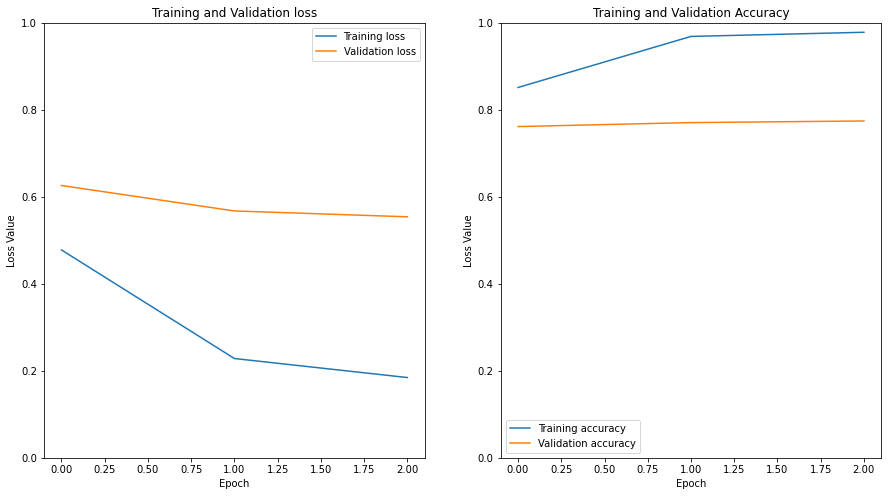

In [28]:
visualize_history(model_history, 'loss')

In [29]:
model.save('./Model_Save/segmentation_epoch3.h5')

### Prediction

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('./Model_Save/segmentation_epoch3.h5')

In [111]:
def load_test_img_numpy(img_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    img = img.astype(np.float32) / 255.0
    return img

def create_test_dataset(img_dir, target_size, batch_size=None) :
    x_img_dir = get_data(img_dir)
    file_name = [x.split('/')[-1][:-4] for x in x_img_dir]
    
    x_img = []

    for i in tqdm(x_img_dir,
                     total=len(x_img_dir),
                     position=0,
                     leave=True):
        img = load_test_img_numpy(i, target_size)
        x_img.append(img)

    dataset = Dataset.from_tensor_slices(x_img)
    
    if batch_size is not None :
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
       
    return dataset, file_name

def step(num) :
    if num < 0.5 :
        return 0
    else :
        return 1
step_func = np.vectorize(step)

In [112]:
PRED_BATCHSIZE = 8

test_dataset, file_names = create_test_dataset(x_test_dir, (IMAGE_SIZE, IMAGE_SIZE), PRED_BATCHSIZE)

  0%|          | 0/1592 [00:00<?, ?it/s]

In [117]:
test_dataset

<RepeatDataset shapes: (8, 256, 256, 3), types: tf.float32>

In [119]:
STEPS = len(get_data(x_test_dir)) / PRED_BATCHSIZE

prediction = model.predict(test_dataset,
                          batch_size = PRED_BATCHSIZE,
                          steps=STEPS)

In [120]:
prediction.shape

(1592, 256, 256, 1)

(1592, 256, 256, 1)
[0.24064662 0.2411402  0.24115779 ... 0.7487063  0.7487824  0.76429045]


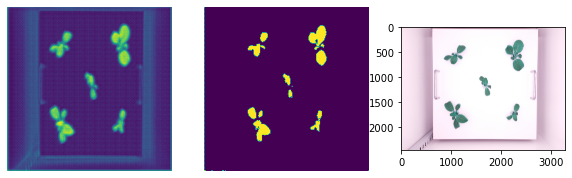

In [153]:
print(prediction.shape)
print(np.unique(prediction[0]))

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(prediction[1000])
ax1.axis('off')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(step_func(prediction[1000]))
ax2.axis('off')

file_name = get_data(x_test_dir)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(cv2.imread(file_name[1000]))

plt.show()

### 이미지 저장

In [145]:
def step(num) :
    if num < 0.5 :
        return 0
    else :
        return 1
step_func = np.vectorize(step)

def transform(predicted_images, save_dir, file_names) :
    transformed = []
    
    for img, name in tqdm(zip(predicted_images, file_names),
                   total=len(predicted_images)):
        image = step_func(img)
        transformed.append(image)
        cv2.imwrite(os.path.join(save_dir, name+'.png'), image)
    print('save done!')

In [149]:
transform(prediction, y_test_dir, file_names)

  0%|          | 0/1592 [00:00<?, ?it/s]

save done!


---
# Augmentation

In [33]:
aug =  A.Compose([
        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomSizedCrop(min_max_height=(100, 201), height=IMAGE_SIZE, width=IMAGE_SIZE, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.Perspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    
        A.CLAHE(p=0.8),
        A.RandomBrightnessContrast(p=0.8),    
        A.RandomGamma(p=0.8)
    ])

/home/ubuntu/anaconda3/envs/machine/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/ubuntu/anaconda3/envs/machine/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/ubuntu/anaconda3/envs/machine/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [31]:
def load_img_not_nomalize(img_dir, mask_dir, target_size) :
    img = cv2.imread(img_dir)
    img = cv2.resize(img, dsize=target_size)
    
    mask = cv2.imread(mask_dir)
    mask = cv2.resize(mask, dsize=target_size)
    mask = mask[..., :1]
    
    return img, mask

In [32]:
def create_aug_dataset(img_dir, mask_dir, target_size, batch_size=None) :
    x_img_dir = get_data(img_dir)
    y_img_dir = get_data(mask_dir)
    
    x_img = [] # 원본이미지
    y_img = [] # 마스크 이미지

    ## 최적화가 필요한 부분
    for i, m in tqdm(zip(x_img_dir, y_img_dir),
                     total=len(x_img_dir),
                     position=0,
                     leave=True):
        img, mask = load_img_not_nomalize(i, m, target_size)
        augmentation = aug(image=img, mask=mask)
        img = augmentation['image'].astype(np.float32) / 255.0
        mask = augmentation['mask'].astype(np.float32)
        x_img.append(img)
        y_img.append(mask)
        
    x = Dataset.from_tensor_slices(x_img)
    y = Dataset.from_tensor_slices(y_img)
    dataset = Dataset.zip((x, y))
    
    if batch_size is not None:
        dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
   
    return dataset

In [34]:
aug_train_dataset = create_aug_dataset(x_train_dir, y_train_dir, (IMAGE_SIZE,IMAGE_SIZE), BATCH_SIZE)
print('train dataset has made!')

  0%|          | 0/228 [00:00<?, ?it/s]

train dataset has made!


https://albumentations.ai/docs/examples/tensorflow-example/

In [35]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model2 = build_unet(input_shape)
model2.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 64) 256         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 64) 0           batch_normalization_36[0][0]     
______________________________________________________________________________________________

In [36]:
model2.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
EPOCHS = 10
STEPS_PER_EPOCH = len(get_data(x_train_dir)) // BATCH_SIZE # 228//4
VAL_STEPS = len(get_data(y_train_dir)) // BATCH_SIZE

In [ ]:
#from tensorflow.keras.callbacks import ModelCheckpoint

#ckpt = ModelCheckpoint('./Model_Save/aug1_checkpoint',
#                      monitor='val_accuracy',
#                      save_best_only=True)

In [38]:
model2_history = model2.fit(aug_train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          validation_steps = VAL_STEPS)
                          # callbacks = [ckpt])

Epoch 1/10
57/57 [==============================] - 20s 319ms/step - loss: 0.5713 - accuracy: 0.7340 - val_loss: 0.7527 - val_accuracy: 0.4146
Epoch 2/10
57/57 [==============================] - 18s 313ms/step - loss: 0.3109 - accuracy: 0.9075 - val_loss: 0.5644 - val_accuracy: 0.7627
Epoch 3/10
57/57 [==============================] - 18s 314ms/step - loss: 0.2549 - accuracy: 0.9304 - val_loss: 0.5285 - val_accuracy: 0.7790
Epoch 4/10
57/57 [==============================] - 18s 315ms/step - loss: 0.2271 - accuracy: 0.9376 - val_loss: 0.5127 - val_accuracy: 0.7807
Epoch 5/10
57/57 [==============================] - 18s 315ms/step - loss: 0.2046 - accuracy: 0.9439 - val_loss: 0.5240 - val_accuracy: 0.7811
Epoch 6/10
57/57 [==============================] - 18s 316ms/step - loss: 0.1899 - accuracy: 0.9481 - val_loss: 0.5322 - val_accuracy: 0.7809
Epoch 7/10
57/57 [==============================] - 18s 316ms/step - loss: 0.1734 - accuracy: 0.9593 - val_loss: 0.5610 - val_accuracy: 0.7806

In [39]:
# model2.save('./Model_Save/segmentation_add_augmentation_epoch50.h5')
model2.save('./Model_Save/segmentation_augmentation_epoch10.h5')

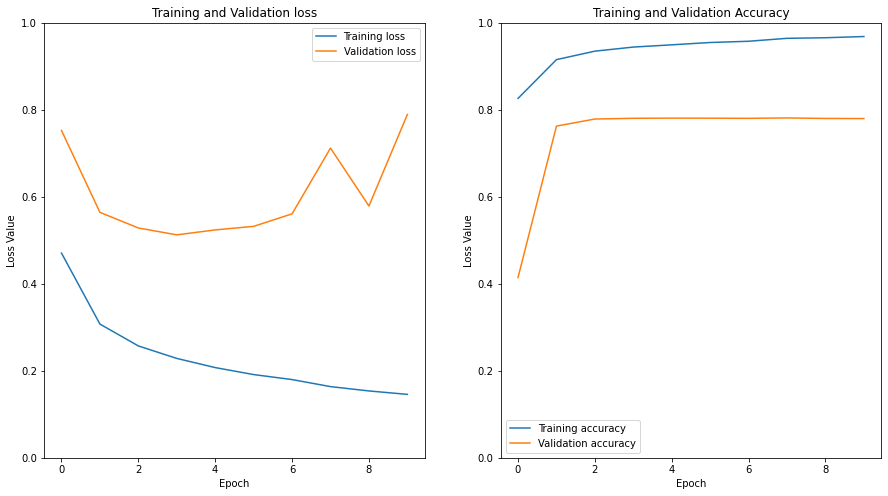

In [40]:
visualize_history(model2_history, 'loss')

### Predict

In [58]:
pred2 = model2.predict(test_dataset)

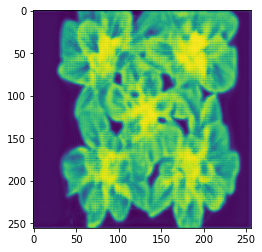

In [59]:
plt.imshow(pred2[-1])

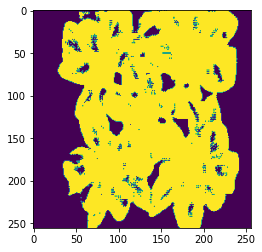

In [60]:
plt.imshow(step_func(pred2[-1]))

___

# Other Metrics_ IOU Score

In [61]:
from tensorflow.keras.metrics import MeanIoU
# import tensorflow_addons as tfa
# from tensorflow_addons.metrics import F1Score

/home/ubuntu/anaconda3/envs/machine/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [63]:
meanIoU = MeanIoU(num_classes=2)

# f1 = F1Score(num_classes=2)

In [65]:
model3 = build_unet(input_shape)
model3.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', meanIoU])

#ckpt = ModelCheckpoint('./Model_Save/aug2_checkpoint',
#                      monitor='val_accuracy',
#                     save_best_only=True)

EPOCHS = 20
model3_history = model3.fit(aug_train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          validation_steps = VAL_STEPS)
                          # callbacks = [ckpt])

Epoch 1/20
57/57 [==============================] - 20s 324ms/step - loss: 0.5675 - accuracy: 0.7461 - mean_io_u: 0.3907 - val_loss: 0.7260 - val_accuracy: 0.4224 - val_mean_io_u: 0.3734
Epoch 2/20
57/57 [==============================] - 18s 318ms/step - loss: 0.3160 - accuracy: 0.9103 - mean_io_u: 0.3934 - val_loss: 0.5641 - val_accuracy: 0.7556 - val_mean_io_u: 0.3734
Epoch 3/20
57/57 [==============================] - 18s 318ms/step - loss: 0.2625 - accuracy: 0.9333 - mean_io_u: 0.3950 - val_loss: 0.5192 - val_accuracy: 0.7775 - val_mean_io_u: 0.3734
Epoch 4/20
57/57 [==============================] - 18s 318ms/step - loss: 0.2416 - accuracy: 0.9360 - mean_io_u: 0.3948 - val_loss: 0.5051 - val_accuracy: 0.7810 - val_mean_io_u: 0.3734
Epoch 5/20
57/57 [==============================] - 18s 318ms/step - loss: 0.2224 - accuracy: 0.9424 - mean_io_u: 0.3944 - val_loss: 0.5150 - val_accuracy: 0.7817 - val_mean_io_u: 0.3734
Epoch 6/20
57/57 [==============================] - 18s 319ms/ste

In [67]:
model3_history.history

{'loss': [0.4771648645401001,
  0.31715646386146545,
  0.26879268884658813,
  0.24591830372810364,
  0.2219325751066208,
  0.19684842228889465,
  0.18773095309734344,
  0.17423325777053833,
  0.16401517391204834,
  0.1549837440252304,
  0.1454259604215622,
  0.12960129976272583,
  0.12141311913728714,
  0.11578734219074249,
  0.1129540205001831,
  0.10547962039709091,
  0.1039418950676918,
  0.09447866678237915,
  0.09208019822835922,
  0.08865303546190262],
 'accuracy': [0.8326576352119446,
  0.9162716269493103,
  0.9372374415397644,
  0.9394388794898987,
  0.9490064382553101,
  0.9580748081207275,
  0.9602904915809631,
  0.9641098380088806,
  0.9657849669456482,
  0.9677412509918213,
  0.9685952663421631,
  0.9735799431800842,
  0.9757657051086426,
  0.9756869077682495,
  0.9769864082336426,
  0.9773038625717163,
  0.9772547483444214,
  0.9794261455535889,
  0.9798023104667664,
  0.9802682995796204],
 'mean_io_u': [0.3932129144668579,
  0.39528995752334595,
  0.3968273997306824,
  0.

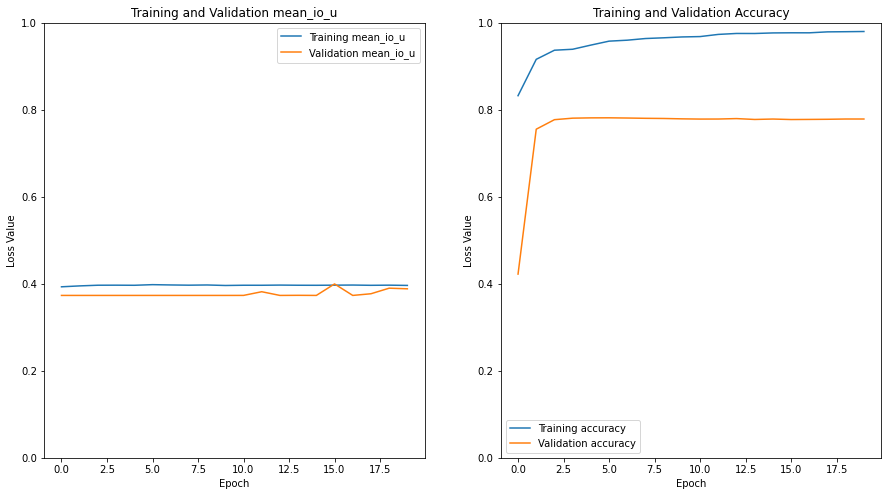

In [70]:
visualize_history(model3_history, 'mean_io_u')

개선 X -> unet api 이용  

- https://github.com/divamgupta/image-segmentation-keras

\<Prerequisites\>  
- Keras ( recommended version : 2.4.3 )  
- OpenCV for Python  
- Tensorflow ( recommended version : 2.4.1 )  